Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
Описание услуг

Оператор предоставляет два основных типа услуг:

    Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
    Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

    Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    Выделенная линия технической поддержки (TechSupport);
    Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных

Данные состоят из файлов, полученных из разных источников:

    contract.csv — информация о договоре;
    personal.csv — персональные данные клиента;
    internet.csv — информация об интернет-услугах;
    phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**План работы**:

1. Анализ и предобработка данных:
- поиск пропущенных значений, аномалий и дубликатов, их обработка;
- создание столбцов с дополнительными фичами и с целевым признаком;
- создание единого датафрейма.

2. Исследовательский анализ данных:
- сравнение распределения различных признаков для ушедших и оставшихся клиентов, построение графиков для наглядности;
- выявление признаков, которые будут лишними и бесполезными при обучении моделей.

3. Работа с моделями:
- подготовка данных для моделей(работа с дисбалансом классов, кодирование, масштабирование);
- обучение моделей, их тестирование и выбор лучшей.

4. Общие выводы.

## Анализ и предобработка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
#from scipy.stats import chi2_contingency


from IPython.display import display
pd.set_option('display.max_columns', 100)
import warnings 
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 19612
ALPHA = 0.05

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

Данные, находящиеся в столбцах датафреймов, почти не описаны. Значит вместе с анализом этих данных будем так же и описывать их.

### Contract

In [4]:
display(contract.head(), contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


None

In [5]:
display(contract['customerID'].duplicated().sum(), 
        contract['Type'].unique(), 
        contract['PaperlessBilling'].unique(), 
        contract['PaymentMethod'].unique())

0

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

В датафрейме **contract** имеются следующие столбцы:
- **'customerID'** - код клиента;
- **'BeginDate'** - дата заключения договора с клиентом;
- **'EndDate'** - дата завершения договора с клиентом;
- **'Type'** - периодичность оплаты услуг клиентом(из месяца в месяц, раз в год, раз в два года);
- **'PaperlessBilling'** - выставление счетов без использования бумаги(электронно);
- **'PaymentMethod'** - способ оплаты услуг клиентом(электронный чек, чек по почте, автоматический банковский перевод или кредитной картой);
- **'MonthlyCharges'** - сумма месячного платежа;
- **'TotalCharges'** - сумма всех платежей клиента.

Дубликатов кодов клиента отсутствуют. Пропуски - тоже. Нужно только:
- изменить тип данных в **'BeginDate'**, **'EndDate'**; 
- заменить значения 'yes/no' на '1/0' в  **'PaperlessBilling'**;
- заполнить пропуски в **'TotalCharges'**;
- добавить пару столбцов, которые помогут в дальнейшем анализе.

In [6]:
# Добавим столбец 'СurrentСlient', где True - клиент остался, False - клиент ушел
contract['СurrentСlient'] = 0
contract.loc[contract['EndDate'] == 'No', 'СurrentСlient'] = 1
#contract['СurrentСlient'] = contract['СurrentСlient'].astype('bool')

In [7]:
# Изменим тип данных в столбеце 'PaperlessBilling'
contract['PaperlessBilling'] = contract['PaperlessBilling'].replace('No', 0)
contract['PaperlessBilling'] = contract['PaperlessBilling'].replace('Yes', 1)
contract['PaperlessBilling'] = contract['PaperlessBilling'].astype('bool')

In [8]:
# Изменим тим данных в столбцах с датой
contract['End_']= contract['EndDate'].replace('No', '2020-02-01')
contract['End_']= pd.to_datetime(contract['End_'], format='%Y-%m-%dT%H:%M:%S')
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate']= pd.to_datetime(contract['EndDate'], format='%Y-%m-%dT%H:%M:%S',errors='coerce')

In [9]:
# Заполним пропуски в 'TotalCharges' для клиентов, которые подключились меньше месяца назад
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

In [10]:
# Добавим столбец 'LifeTime', в котором посчитаем сколько дней данный человек является(являлся) нашим клиентом
contract['LifeTime'] = (contract['End_'] - contract['BeginDate']).dt.days

In [11]:
# Удаляем ненужный столбец
contract = contract.drop('End_', axis=1)

In [12]:
display(contract.head(10), contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   bool          
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   СurrentСlient     7043 non-null   int64         
 9   LifeTime          7043 non-null   int64         
dtypes: bool(1), datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 502.2+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СurrentСlient,LifeTime
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,True,Electronic check,29.85,29.85,1,31
1,5575-GNVDE,2017-04-01,NaT,One year,False,Mailed check,56.95,1889.50,1,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,0,61
3,7795-CFOCW,2016-05-01,NaT,One year,False,Bank transfer (automatic),42.30,1840.75,1,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,0,61
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,True,Electronic check,99.65,820.50,0,245
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,True,Credit card (automatic),89.10,1949.40,1,671
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,False,Mailed check,29.75,301.90,1,306
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,True,Electronic check,104.80,3046.05,0,853
9,6388-TABGU,2014-12-01,NaT,One year,False,Bank transfer (automatic),56.15,3487.95,1,1888


None

### Personal

In [13]:
display(personal.head(), personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


None

In [14]:
display(personal['customerID'].duplicated().sum(), 
        personal['gender'].unique(), 
        personal['SeniorCitizen'].unique(), 
        personal['Partner'].unique(), 
        personal['Dependents'].unique())

0

array(['Female', 'Male'], dtype=object)

array([0, 1])

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

В датафрейме **contract** имеются следующие столбцы:

- **'customerID'** - код клиента;
- **'gender'** - пол клиента;
- **'SeniorCitizen'** - является ли клиент пенсионером;
- **'Partner'** - состоит ли клиент в браке;
- **'Dependents'** - есть ли у клиента иждивенцы.

Дубликаты в **'customerID'** отсутствуют. Все остальные столбцы имеют бинарные значения, поэтому можно их перевести в булев тип.

In [15]:
# Сменим тип данных столбца 'SeniorCitizen' на булев тип
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('bool')

In [16]:
# Сменим тип данных столбца 'Partner' на булев тип
personal['Partner'] = personal['Partner'].replace('No', 0)
personal['Partner'] = personal['Partner'].replace('Yes', 1)
personal['Partner'] = personal['Partner'].astype('bool')

In [17]:
# Сменим тип данных столбца 'Dependents' на булев тип
personal['Dependents'] = personal['Dependents'].replace('No', 0)
personal['Dependents'] = personal['Dependents'].replace('Yes', 1)
personal['Dependents'] = personal['Dependents'].astype('bool')

In [18]:
display(personal.head(), personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   bool  
 3   Partner        7043 non-null   bool  
 4   Dependents     7043 non-null   bool  
dtypes: bool(3), object(2)
memory usage: 130.8+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,False,True,False
1,5575-GNVDE,Male,False,False,False
2,3668-QPYBK,Male,False,False,False
3,7795-CFOCW,Male,False,False,False
4,9237-HQITU,Female,False,False,False


None

### Internet

In [19]:
display(internet.head(), internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


None

In [20]:
display(internet['customerID'].duplicated().sum(), 
        internet['InternetService'].unique(), 
        internet['OnlineSecurity'].unique(), 
        internet['OnlineBackup'].unique(), 
        internet['DeviceProtection'].unique(), 
        internet['TechSupport'].unique(), 
        internet['StreamingTV'].unique(), 
        internet['StreamingMovies'].unique())

0

array(['DSL', 'Fiber optic'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

В датафрейме **internet** имеются следующие столбцы:

- **'customerID'** - код клиента;
- **'InternetService'** - наличие подключения услуги Internet Service;
- **'OnlineSecurity'** - наличие подключения услуги Online Security;
- **'OnlineBackup'** - наличие подключения услуги Online Backup;
- **'DeviceProtection'** - наличие подключения услуги Device Protection;
- **'TechSupport'** - наличие подключения услуги Tech Support;
- **'StreamingTV'** - наличие подключения услуги Streaming TV;
- **'StreamingMovies'** - наличие подключения услуги Streaming Movies.

Дубликаты в **'customerID'** отсутствуют. 

### Phone

In [21]:
display(phone.head(), phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


None

In [22]:
display(phone['customerID'].duplicated().sum(), phone['MultipleLines'].unique())

0

array(['No', 'Yes'], dtype=object)

В датафрейме **phone** имеются следующие столбцы:

- **'customerID'** - код клиента;
- **'MultipleLines'** - наличие подключения услуги Multiple Lines.

Дубликаты в **'customerID'** отсутствуют.

### Создание единого датафрейма

Объединим все данные в один датафрейм

In [23]:
full = pd.merge(personal, contract, on = 'customerID', how = 'left')

In [24]:
full = pd.merge(full, phone, on ='customerID',how= 'left')

In [25]:
full = pd.merge(full, internet, on ='customerID',how= 'left')

In [26]:
display(full.head(), full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   bool          
 3   Partner           7043 non-null   bool          
 4   Dependents        7043 non-null   bool          
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   bool          
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  СurrentСlient     7043 non-null   int64         
 13  LifeTime          7043 non-null   int64         
 14  MultipleLines     6361 n

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СurrentСlient,LifeTime,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,False,True,False,2020-01-01,NaT,Month-to-month,True,Electronic check,29.85,29.85,1,31,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,False,False,False,2017-04-01,NaT,One year,False,Mailed check,56.95,1889.50,1,1036,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,False,False,False,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,0,61,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,False,False,False,2016-05-01,NaT,One year,False,Bank transfer (automatic),42.30,1840.75,1,1371,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,False,False,False,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,0,61,No,Fiber optic,No,No,No,No,No,No


None

После объединения таблиц в некоторых столбцах появились пропущенные значения. Они возникли из-за того, что не каждый клиент пользовался услугами и телефонии и интернета одновременно. Заполним эти пропуски.

In [27]:
for i in ['MultipleLines', 
          'InternetService', 
          'OnlineSecurity', 
          'OnlineBackup', 
          'DeviceProtection', 
          'TechSupport', 
          'StreamingTV', 
          'StreamingMovies']:
    #full[i] = full[i].replace('No', 0)
    #full[i] = full[i].replace('Yes', 1)
    full[i] = full[i].fillna('disabled')
print('Пропуски заполнены')

Пропуски заполнены


In [28]:
display(full.head(), full.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   bool          
 3   Partner           7043 non-null   bool          
 4   Dependents        7043 non-null   bool          
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           1869 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   bool          
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   float64       
 12  СurrentСlient     7043 non-null   int64         
 13  LifeTime          7043 non-null   int64         
 14  MultipleLines     7043 n

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СurrentСlient,LifeTime,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,False,True,False,2020-01-01,NaT,Month-to-month,True,Electronic check,29.85,29.85,1,31,disabled,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,False,False,False,2017-04-01,NaT,One year,False,Mailed check,56.95,1889.50,1,1036,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,False,False,False,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,0,61,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,False,False,False,2016-05-01,NaT,One year,False,Bank transfer (automatic),42.30,1840.75,1,1371,disabled,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,False,False,False,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,0,61,No,Fiber optic,No,No,No,No,No,No


None

### Вывод:

Дубликатов в данных нет. Пропусков в первичных таблицах - тоже. Часть данных была переведена в другой формат. Были добавлены столбцы **'СurrentСlient'**(признак того, остался клиент или ушел) и **'LifeTime'**("время жизни" клиента).

## Исследовательский анализ данных.

Для  начала узнаем, сколько клиентов ушли.

In [29]:
print('Количество ушедших:', full[(full['СurrentСlient']==0)]['СurrentСlient'].count(), 
      '(', 
      round((full[(full['СurrentСlient']==0)]['СurrentСlient'].count() / full.shape[0]) * 100, 2),
      '% от общего количества клиентов)')

Количество ушедших: 1869 ( 26.54 % от общего количества клиентов)


Рассмотрим годы подключения и отключения ушедших клиентов.

In [30]:
# добавим столбцы в годом подключения и отключения клиента
full['BeginYear'] = pd.DatetimeIndex(full['BeginDate']).year
full['EndYear'] = pd.DatetimeIndex(full['EndDate']).year
full['EndYear'] = full['EndYear'].fillna(2021).astype('int')
full.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СurrentСlient,LifeTime,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginYear,EndYear
0,7590-VHVEG,Female,False,True,False,2020-01-01,NaT,Month-to-month,True,Electronic check,29.85,29.85,1,31,disabled,DSL,No,Yes,No,No,No,No,2020,2021
1,5575-GNVDE,Male,False,False,False,2017-04-01,NaT,One year,False,Mailed check,56.95,1889.50,1,1036,No,DSL,Yes,No,Yes,No,No,No,2017,2021
2,3668-QPYBK,Male,False,False,False,2019-10-01,2019-12-01,Month-to-month,True,Mailed check,53.85,108.15,0,61,No,DSL,Yes,Yes,No,No,No,No,2019,2019
3,7795-CFOCW,Male,False,False,False,2016-05-01,NaT,One year,False,Bank transfer (automatic),42.30,1840.75,1,1371,disabled,DSL,Yes,No,Yes,Yes,No,No,2016,2021
4,9237-HQITU,Female,False,False,False,2019-09-01,2019-11-01,Month-to-month,True,Electronic check,70.70,151.65,0,61,No,Fiber optic,No,No,No,No,No,No,2019,2019


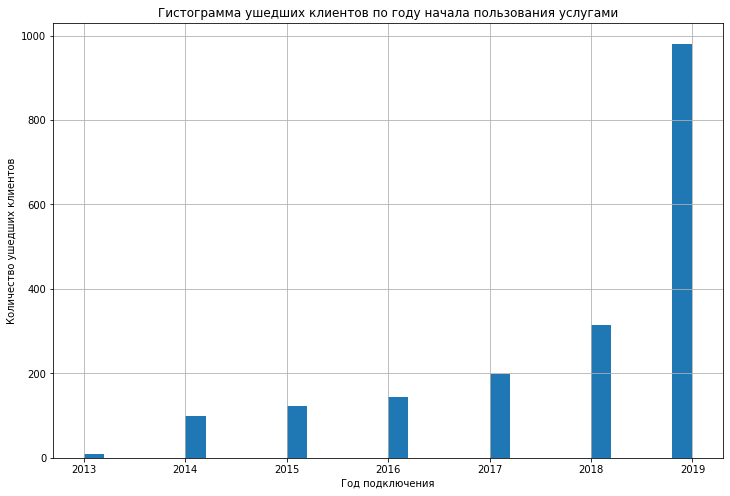

In [31]:
plt.figure(figsize=(12,8))
full.query('СurrentСlient == False')['BeginYear'].plot(kind='hist', bins=30, grid=True)
plt.title('Гистограмма ушедших клиентов по году начала пользования услугами')
plt.xlabel('Год подключения')
plt.ylabel('Количество ушедших клиентов')
plt.show()

In [32]:
full.query('СurrentСlient == False')['EndYear'].unique()

array([2019, 2020])

Клиенты начали уходить в 2019 году и большая часть этих клиентов в 2019 году и подключилась.

Теперь рассмотрим соотношение ушедших и оставшихся приентов по некоторым признакам.

In [33]:
def his(col, xlab):
    plt.figure(figsize=(12,8))
    sns.countplot(x = col, hue = 'СurrentСlient', data = full)
    plt.title('Сравнение клиентов по столбцу ' + col)
    plt.xlabel(xlab)
    plt.ylabel('Количество клиентов')
    plt.legend(['Ушедшие клиенты', 'Актуальные клиенты'])
    plt.grid('True')
    plt.show()

**Пол клиента**.

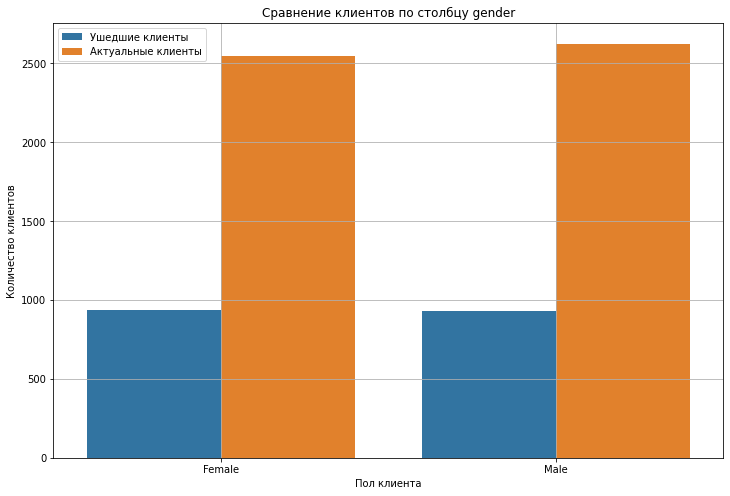

In [34]:
his('gender', 'Пол клиента')

Распределение по полу оставшихся и ушедших клиентов одинаковое - 50%/50%. Признак не несет никакой информации, которая поможет в обучении модели, его можно удалить.

**Пенсионеры.**

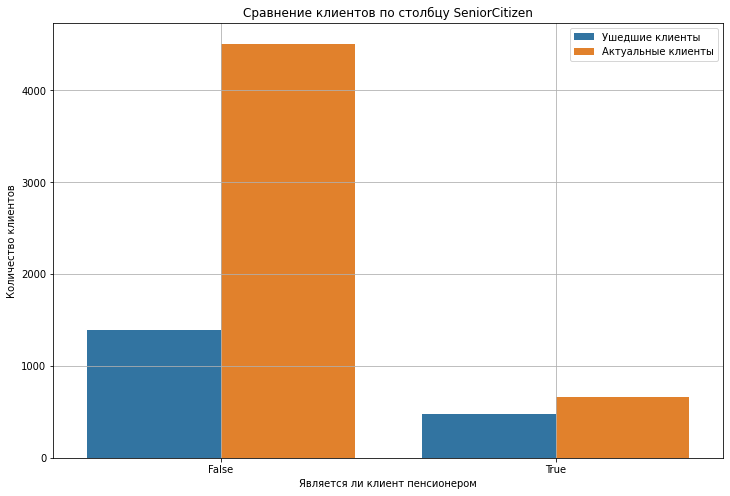

In [35]:
his('SeniorCitizen', 'Является ли клиент пенсионером')

Среди пенсионеров количество ушедших и оставшихся отличается на 10%-15% в пользу вторых. Среди не пенсионеров доля актуальных клиентов превышает долю ушедших в 3 раза. Соотношение ушедших пенсионеров к не пенсионерам примерно 1:3.

**Наличие супруга.**

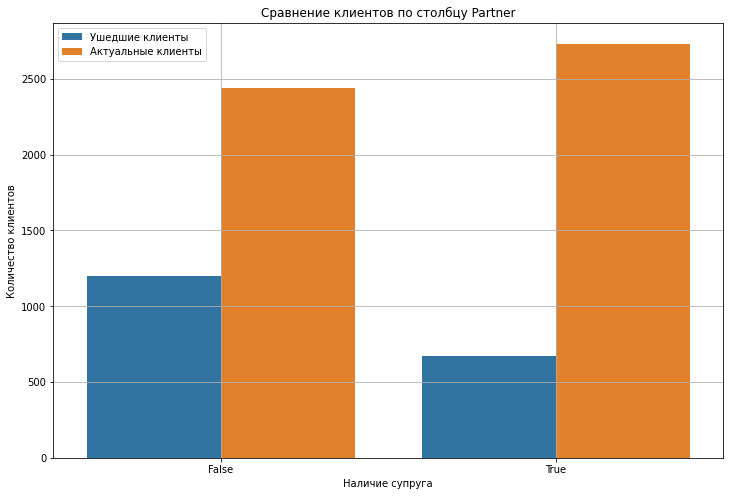

In [36]:
his('Partner', 'Наличие супруга')

Среди ушедших клиентов доля не состоящих в браке выше примерно в 2 раза.

**Наличие иждивенцев.**

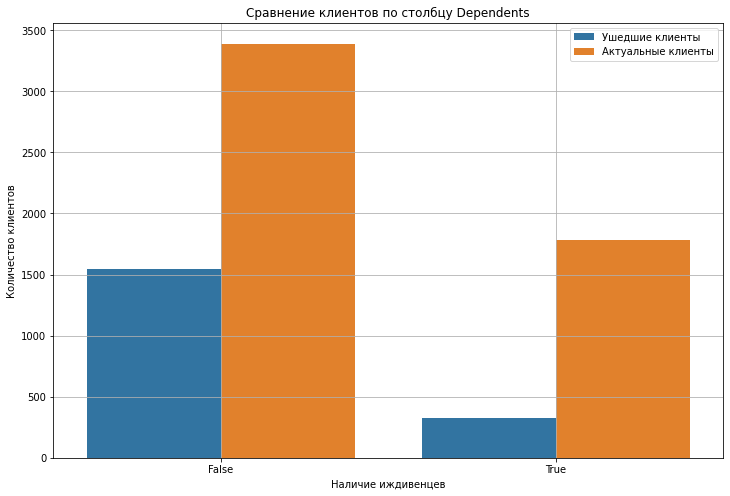

In [37]:
his('Dependents', 'Наличие иждивенцев')

Среди ушедших клиентов в 5 раз больше тех, кто не имеет иждивенцев.

**Тип оплаты.**

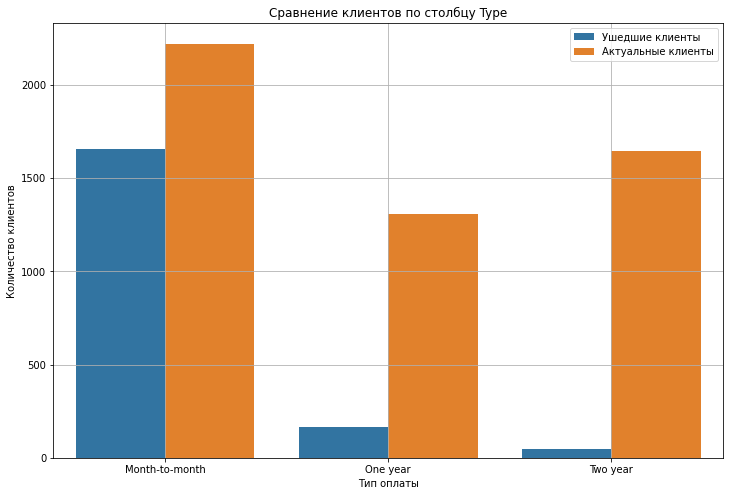

In [38]:
his('Type', 'Тип оплаты')

Около 90% ушедших клиентов пользовались помесячной оплатой услуг провайдера.

**Использование интернет-услуг.**

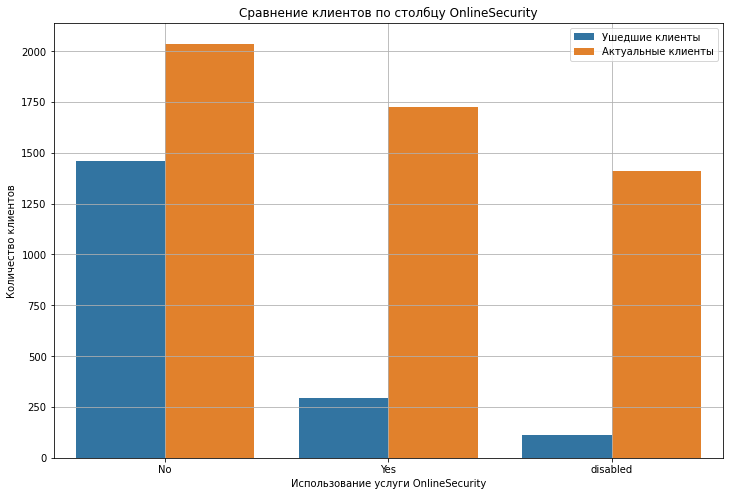

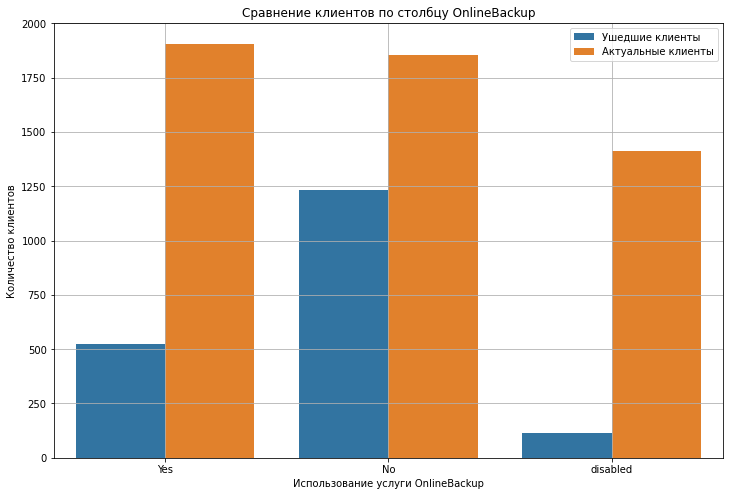

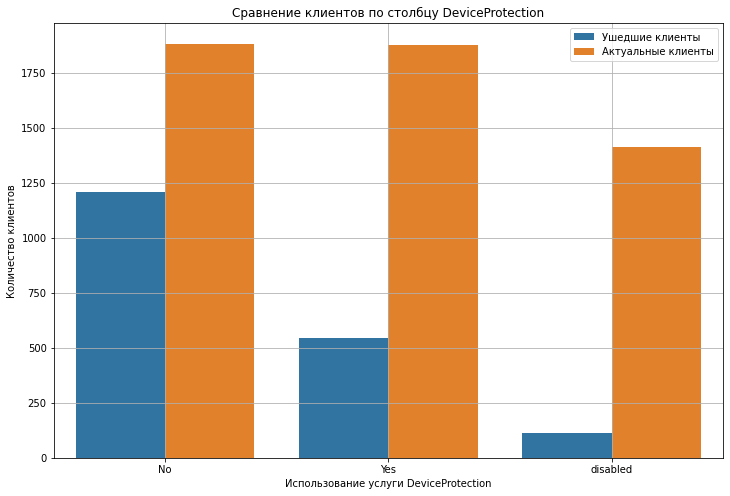

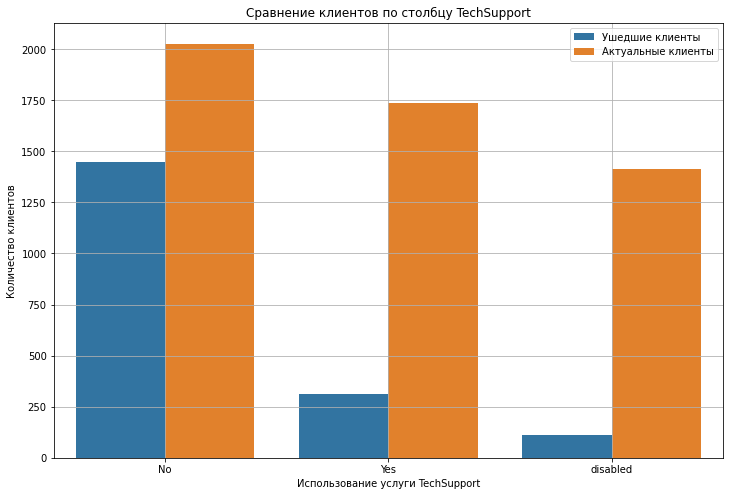

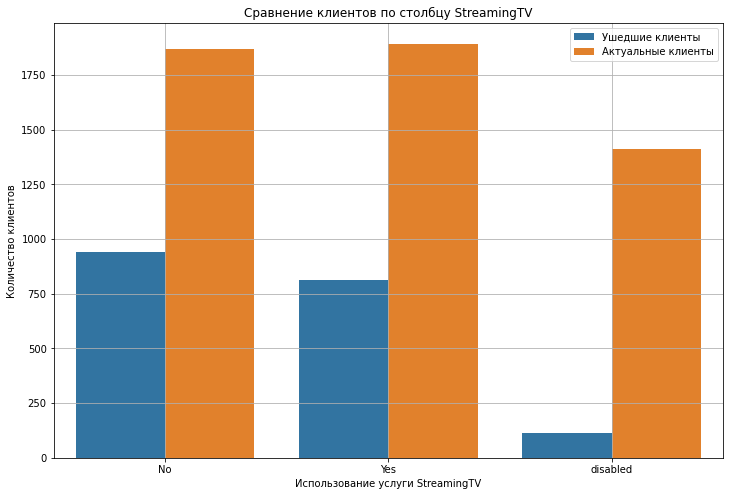

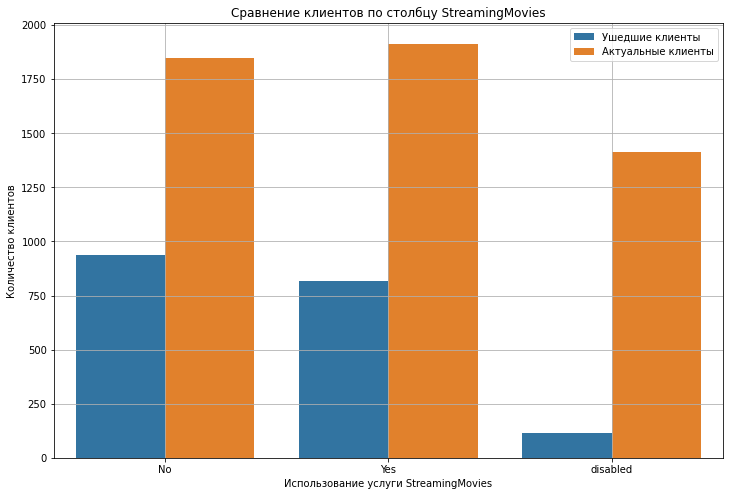

In [39]:
for i in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    his(i, 'Использование услуги ' + i)

**Тип интернет подключения.**

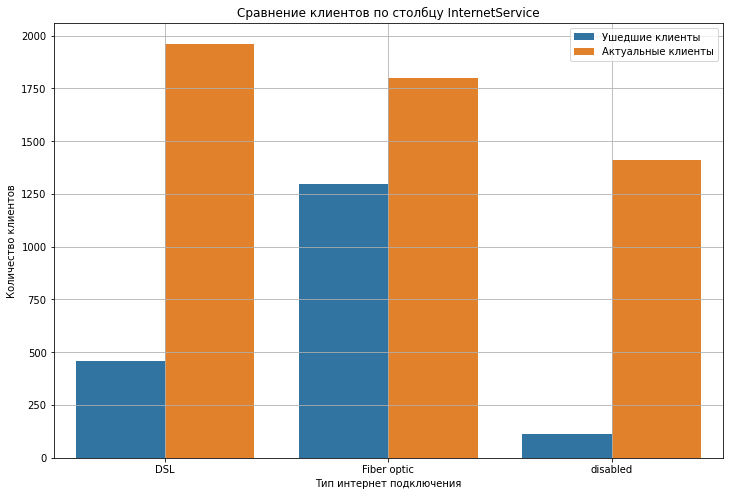

In [40]:
his('InternetService', 'Тип интернет подключения')

Значительная часть ушедших клиентов пользовалась интернетом через оптоволоконное подключение.

**Размер ежемесячных платежей.**

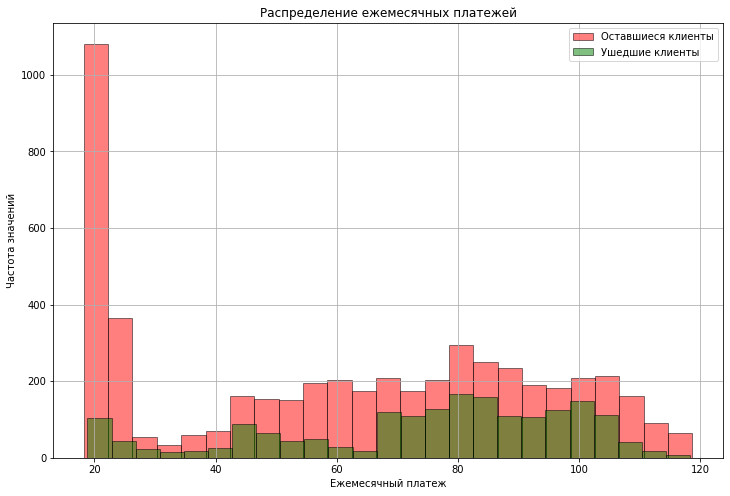

In [41]:
ax = full.query('СurrentСlient == True').plot(kind = 'hist', 
                                              y = 'MonthlyCharges', 
                                              ec = 'black', 
                                              bins = 25,
                                              linewidth = 1, 
                                              alpha = 0.5, 
                                              label = 'Оставшиеся клиенты', 
                                              color = 'r')

full.query('СurrentСlient == False').plot(kind = 'hist', 
                                          y = 'MonthlyCharges', 
                                          ec = 'black', 
                                          bins = 25,
                                          linewidth = 1, 
                                          alpha = 0.5, 
                                          label = 'Ушедшие клиенты', 
                                          ax = ax, 
                                          figsize = (12,8),
                                          grid = True, 
                                          color = 'g')

ax.set_xlabel('Ежемесячный платеж')
ax.set_ylabel('Частота значений')
ax.set_title('Распределение ежемесячных платежей')
plt.show()

In [42]:
print('Медианное значение месячного платежа: \nу оставшихся -', 
      round(full.query('СurrentСlient == True')['MonthlyCharges'].median()),
      '\nу ушедших -',
      round(full.query('СurrentСlient == False')['MonthlyCharges'].median()))

Медианное значение месячного платежа: 
у оставшихся - 64 
у ушедших - 80


Из графика видно, что среди ушедших клиентов большая часть имела месячный платеж от 70 до 110. У оставшихся основное распределение платежа лежит в диапазоне от 45 до 110. Однако и у тех, у и других плиентов есть всплески у минимумов.
Медианное значение также выше у ушедших клиентов.

**Время жизни клиента.**

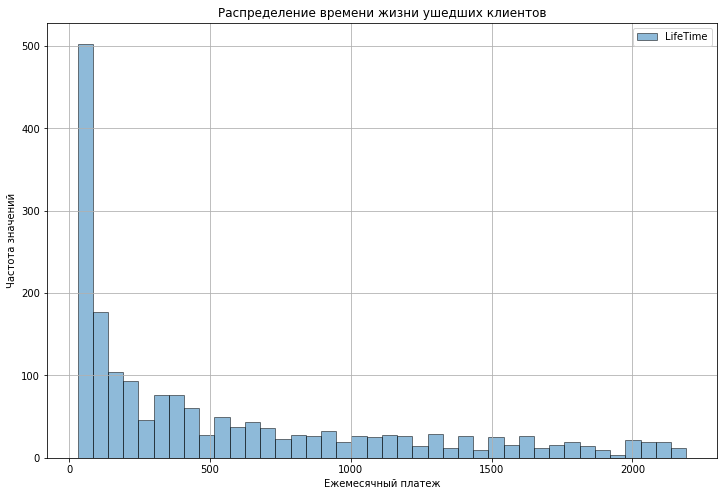

In [43]:
full.query('СurrentСlient == False').plot(kind = 'hist', 
                                          y = 'LifeTime', 
                                          ec = 'black', 
                                          bins = 40,
                                          linewidth = 1, 
                                          alpha = 0.5,  
                                          figsize = (12,8),
                                          grid = True)

plt.xlabel('Ежемесячный платеж')
plt.ylabel('Частота значений')
plt.title('Распределение времени жизни ушедших клиентов')
plt.show()

In [44]:
lt = full.query('СurrentСlient == False').pivot_table(index = 'LifeTime', values = 'customerID', aggfunc = 'count')
lt.columns = ['count']
display(lt.sort_values(by = 'count', ascending = False).head())

,count
LifeTime,
31,198
30,182
61,123
153,64
92,63


Из распределения видно, что большая часть ушедших - это "молодые" клиенты. Значительная часть клиентов ушли в через 1-2 месяца после подключения.

### Вывод:

Количество ушедших клиентов - 1869, что составляет 26.54 % от их общего количества. Начали отключаться клиенты с 2019 года и максимум отключившихся приходится на подключившихся в том же году. Среди ушедших клиентов преобладают люди допенсионного возраста, без детей и супруга, а так же те, что пользовался интернетом через оптоволокно.
Около 90% ушедших клиентов пользовались помесячной оплатой услуг провайдера. Так же в среднем месячная плата ушедших клиентов была выше, чем у оставшихся. Медианное значение - 80 против 64 у оставшихся.
Так же выяснилось, что чем меньше человек являлся клиентом компании, тем выше была вероятноть того, что он отключится. Значительная часть клиентов ушли после первого-второго месяца пользования услуг компании.

Есть вероятность того, что у компании либо изменилась ценовая политика(или же понизилось качество оказываемых услуг и поддержки), либо появился конкурент.

## Работа с моделями.

### Подготовка данных.

Для начала удалим признаки с датами и годами, чтобы избежать утечки данных. Так же удалим признак пола и ID клиента, так как от них совсем не зависит, уйдет ли клиент или нет.

In [45]:
full = full.drop(['customerID', 'gender', 'BeginDate', 'EndDate', 'BeginYear', 'EndYear'], axis=1)

Рассмотрим корреляцию признаков между собой.

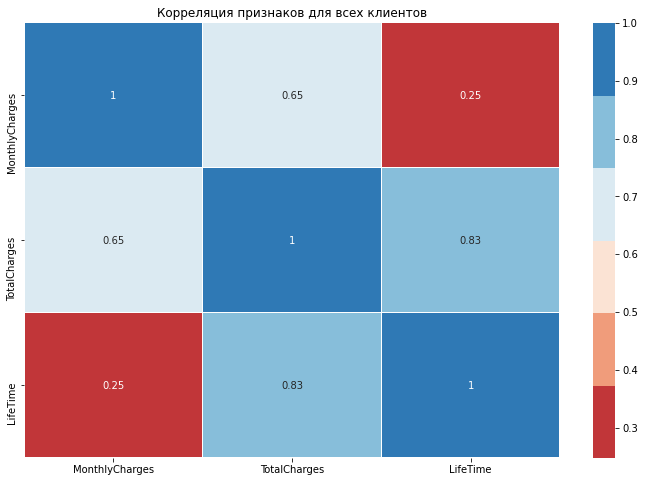

In [46]:
plt.figure(figsize = (12,8))
sns.heatmap(full[['MonthlyCharges', 'TotalCharges', 'LifeTime']].corr(),cmap = sns.color_palette(palette="RdBu"), linewidths = 0.1, annot=True).title.set_text('Корреляция признаков для всех клиентов')
plt.show()

Мы видим большую корреляцию признака **'TotalCharges'** с **'LifeTime'** (0,83) и так как **'TotalCharges'** коррелирует и с **'MonthlyCharges'** (0,65), то для предотвращения переобучения модели избавимся именно от признака **'TotalCharges'**.

In [47]:
full = full.drop(['TotalCharges'], axis=1)

Объединим данные по интернет-услугам в один столбец - количество используемых услуг.

In [48]:
for i in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    full[i] = full[i].replace(['No', 'disabled'], 0)
    full[i] = full[i].replace('Yes', 1)
full['IntServiceCount'] = full['OnlineSecurity']+full['OnlineBackup']+full['DeviceProtection']+full['TechSupport']+full['StreamingTV']+full['StreamingMovies']
full['IntServiceCount'] = full['IntServiceCount'].astype('int')
full = full.drop(['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'],axis=1)

От лишних признаков мы избавились. 
Дисбаланс классов у нас примерно 1:3(ушедших клиентов около 27%). Я считаю, что это не такой большой дисбаланс, с которым необходимо бороться дополнительным преобразованием датасета(upsampling'ом, например). Однако при разделении на выборки дисбаланс можно учесть.

#### Кодирование признаков.

In [49]:
display(full.columns, full.head())

Index(['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'СurrentСlient', 'LifeTime',
       'MultipleLines', 'InternetService', 'IntServiceCount'],
      dtype='object')

,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,СurrentСlient,LifeTime,MultipleLines,InternetService,IntServiceCount
0,False,True,False,Month-to-month,True,Electronic check,29.85,1,31,disabled,DSL,1
1,False,False,False,One year,False,Mailed check,56.95,1,1036,No,DSL,2
2,False,False,False,Month-to-month,True,Mailed check,53.85,0,61,No,DSL,2
3,False,False,False,One year,False,Bank transfer (automatic),42.30,1,1371,disabled,DSL,3
4,False,False,False,Month-to-month,True,Electronic check,70.70,0,61,No,Fiber optic,0


In [50]:
full_cat = full.copy()

cat_features = ['Type', 
                'PaymentMethod', 
                'MultipleLines',
                'InternetService']

num_features = ['MonthlyCharges', 'LifeTime', 'IntServiceCount']
full = pd.get_dummies(full, drop_first = True)
print('Данные закодированы')

Данные закодированы


In [51]:
full.head()

,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,СurrentСlient,LifeTime,IntServiceCount,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes,MultipleLines_disabled,InternetService_Fiber optic,InternetService_disabled
0,False,True,False,True,29.85,1,31,1,0,0,0,1,0,0,1,0,0
1,False,False,False,False,56.95,1,1036,2,1,0,0,0,1,0,0,0,0
2,False,False,False,True,53.85,0,61,2,0,0,0,0,1,0,0,0,0
3,False,False,False,False,42.30,1,1371,3,1,0,0,0,0,0,1,0,0
4,False,False,False,True,70.70,0,61,0,0,0,0,1,0,0,0,1,0


#### Создание обучающей и тестовой выборок

In [52]:
# Кодированные данные
X = full.drop('СurrentСlient',axis=1)
y = full['СurrentСlient']
print('Целевой признак отделен.')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_STATE, stratify = y)
print('Размер обучающей выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Целевой признак отделен.
Размер обучающей выборки: (5634, 16)
Размер тестовой выборки: (1409, 16)


In [53]:
# Некодированные данные
X_cat = full_cat.drop('СurrentСlient',axis=1)
y_cat = full_cat['СurrentСlient']
print('Целевой признак отделен.')
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state = RANDOM_STATE, stratify = y_cat)
print('Размер обучающей выборки:', X_cat_train.shape)
print('Размер тестовой выборки:', X_cat_test.shape)

Целевой признак отделен.
Размер обучающей выборки: (5634, 11)
Размер тестовой выборки: (1409, 11)


#### Стандартизация признаков.

In [54]:
display(X_train, X_cat_train, num_features)


,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,LifeTime,IntServiceCount,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes,MultipleLines_disabled,InternetService_Fiber optic,InternetService_disabled
2453,True,False,False,True,74.45,123,0,0,0,0,1,0,1,0,1,0
4211,True,False,False,True,102.95,730,4,0,0,1,0,0,1,0,1,0
633,False,False,False,False,20.35,306,0,1,0,0,0,1,0,0,0,1
2111,False,True,True,False,21.25,914,0,0,1,0,0,1,0,0,0,1
4703,True,True,False,True,78.85,730,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,False,False,False,False,25.45,153,0,0,0,0,0,1,1,0,0,1
5495,False,False,False,True,73.85,335,1,0,0,0,1,0,0,0,1,0
3502,False,False,False,True,54.00,1340,4,1,0,0,1,0,0,1,0,0
4898,False,False,False,False,25.25,92,0,0,0,0,1,0,0,1,0,0


,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,LifeTime,MultipleLines,InternetService,IntServiceCount
2453,True,False,False,Month-to-month,True,Electronic check,74.45,123,Yes,Fiber optic,0
4211,True,False,False,Month-to-month,True,Credit card (automatic),102.95,730,Yes,Fiber optic,4
633,False,False,False,One year,False,Mailed check,20.35,306,No,disabled,0
2111,False,True,True,Two year,False,Mailed check,21.25,914,No,disabled,0
4703,True,True,False,Month-to-month,True,Electronic check,78.85,730,Yes,Fiber optic,1
...,...,...,...,...,...,...,...,...,...,...,...
3765,False,False,False,Month-to-month,False,Mailed check,25.45,153,Yes,disabled,0
5495,False,False,False,Month-to-month,True,Electronic check,73.85,335,No,Fiber optic,1
3502,False,False,False,One year,True,Electronic check,54.00,1340,disabled,DSL,4
4898,False,False,False,Month-to-month,False,Electronic check,25.25,92,disabled,DSL,0


['MonthlyCharges', 'LifeTime', 'IntServiceCount']

In [55]:
# Кодированные данные
Scaler = StandardScaler()
X_train[num_features] = Scaler.fit_transform(X_train[num_features])
X_test[num_features] = Scaler.transform(X_test[num_features])
print('Признаки кодированного датасета стандартизированы.')
display(X_train.head())

Признаки кодированного датасета стандартизированы.


,SeniorCitizen,Partner,Dependents,PaperlessBilling,MonthlyCharges,LifeTime,IntServiceCount,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes,MultipleLines_disabled,InternetService_Fiber optic,InternetService_disabled
2453,True,False,False,True,0.327815,-1.158865,-1.105974,0,0,0,1,0,1,0,1,0
4211,True,False,False,True,1.277819,-0.347100,1.063237,0,0,1,0,0,1,0,1,0
633,False,False,False,False,-1.475526,-0.914132,-1.105974,1,0,0,0,1,0,0,0,1
2111,False,True,True,False,-1.445526,-0.101030,-1.105974,0,1,0,0,1,0,0,0,1
4703,True,True,False,True,0.474483,-0.347100,-0.563671,0,0,0,1,0,1,0,1,0


In [56]:
# Некодированные данные
Scaler = StandardScaler()
X_cat_train[num_features] = Scaler.fit_transform(X_cat_train[num_features])
X_cat_test[num_features] = Scaler.transform(X_cat_test[num_features])
print('Признаки некодированного датасета стандартизированы.')
display(X_cat_train.head())

Признаки некодированного датасета стандартизированы.


,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,LifeTime,MultipleLines,InternetService,IntServiceCount
2453,True,False,False,Month-to-month,True,Electronic check,0.327815,-1.158865,Yes,Fiber optic,-1.105974
4211,True,False,False,Month-to-month,True,Credit card (automatic),1.277819,-0.347100,Yes,Fiber optic,1.063237
633,False,False,False,One year,False,Mailed check,-1.475526,-0.914132,No,disabled,-1.105974
2111,False,True,True,Two year,False,Mailed check,-1.445526,-0.101030,No,disabled,-1.105974
4703,True,True,False,Month-to-month,True,Electronic check,0.474483,-0.347100,Yes,Fiber optic,-0.563671


### Обучение и тестирование моделей.

In [57]:
# Вывод параметров модели
def print_basic_metrics(target_valid, predicted_valid, model, features_valid, model_name, roc_auc_train, acc_train):
    accuracy = accuracy_score(target_valid,predicted_valid)
    roc_auc = roc_auc_score(target_valid,model.predict_proba(features_valid)[::,1])
    recall = recall_score(target_valid,predicted_valid)
    precision = precision_score(target_valid,predicted_valid)    
    print()
    print('\033[1m'+'Метрики для модели '+model_name+' (на тестовых данных)'+'\033[0m')
    print()
    print(f"Значение меры auc roc = {roc_auc:.5f}")
    print(f"Значение меры accuracy = {accuracy:.5f}")
    print(f"Значение меры recall = {recall:.5f}")
    print(f"Значение меры precision = {precision:.5f}")
    return accuracy, recall, precision, roc_auc

In [58]:
# Добавление параметров лучшей модели в датасет для сравнения лучших
def add_to_model_types_compare(mtc,mod_name,roc_auc_train,roc_auc_test,time, acc_train, acc_test):
    mtc = mtc.append({'model_name':mod_name,
                      'acc (train)':acc_train,
                      'acc (test)':acc_test,
                      'ROC AUC (train)':roc_auc_train,
                      'ROC AUC (test)':roc_auc_test,
                      'fit time':time},ignore_index = True)
    display(mtc)
    return mtc
model_types_compare = pd.DataFrame()
print('Датасет для сравнения моделей успешно создан')

Датасет для сравнения моделей успешно создан


In [59]:
# Подбор гиперпараметров и выбор лучшей модели
def find_best_model(model, 
                    params, 
                    features_train, 
                    target_train, 
                    features_test, 
                    target_test, 
                    mtc, 
                    mod_name, 
                    mod_lib, 
                    cat_features):
    
    grd = GridSearchCV(estimator = model, param_grid = params, 
                               cv = 5, n_jobs = -1, scoring = 'roc_auc')
    if mod_lib == 'CB':
        grd.fit(features_train, target_train,cat_features = cat_features)
    elif mod_lib == 'SL':
        grd.fit(features_train, target_train)
    elif mod_lib == 'LGBM':
        grd.fit(features_train, target_train,categorical_feature = 'auto')
    bp = grd.best_params_
    est = grd.best_estimator_
    
    pred = est.predict(features_test)
    train_pred = est.predict(features_train)
    
    train_score = roc_auc_score(target_train,est.predict_proba(features_train)[::,1])
    test_score = roc_auc_score(target_test,est.predict_proba(features_test)[::,1])
    time = grd.refit_time_
    acc_train = accuracy_score(target_train,train_pred)
    acc_test = accuracy_score(target_test,pred)
    
    mtc = add_to_model_types_compare(mtc,mod_name,train_score,test_score,time,acc_train,acc_test)
    print_basic_metrics(target_test, pred, est, features_test,mod_name,train_score,acc_train)
    print('Параметры лучшей модели:')
    print(grd.best_params_)
    return mtc, est, bp

#### Константная модель

In [60]:
pred_bl = [1] * y.shape[0]
roc_auc_bl = roc_auc_score(y.values, pred_bl)
accuracy_bl = accuracy_score(y.values, pred_bl)
print('\033[1m'+'Метрики для константной модели '+'\033[0m')
print()
print(f"Значение меры auc roc = {roc_auc_bl:.5f}")
print(f"Значение меры accuracy = {accuracy_bl:.5f}")

Метрики для константной модели 

Значение меры auc roc = 0.50000
Значение меры accuracy = 0.73463


#### Дерево решений

In [61]:
%%time
dec_tree = DecisionTreeClassifier()
depth_list = [i for i in range(1,50)]
params = {'max_depth':depth_list,'random_state':[RANDOM_STATE],'class_weight':[None,'balanced']}
model_types_compare, best_DT, best_DT_BP = find_best_model(dec_tree,params,
                                                           X_train,
                                                           y_train,
                                                           X_test,
                                                           y_test,
                                                           model_types_compare,
                                                           'DecisionTree',
                                                           'SL',
                                                           [])

,ROC AUC (test),ROC AUC (train),acc (test),acc (train),fit time,model_name
0,0.862795,0.872742,0.823989,0.824281,0.013037,DecisionTree



Метрики для модели DecisionTree (на тестовых данных)

Значение меры auc roc = 0.86280
Значение меры accuracy = 0.82399
Значение меры recall = 0.92560
Значение меры precision = 0.84854
Параметры лучшей модели:
{'class_weight': None, 'max_depth': 6, 'random_state': 19612}
CPU times: user 9.77 s, sys: 18.3 ms, total: 9.79 s
Wall time: 9.8 s


#### Случайный лес

In [62]:
%%time
random_forest = RandomForestClassifier()
depth_list = [i for i in range(2,12)]
estim_list = [i for i in range(45,75,5)]
params = {'max_depth':depth_list,'n_estimators':estim_list,'random_state':[RANDOM_STATE],'class_weight':[None,'balanced']}
model_types_compare,best_RF,best_RF_BP = find_best_model(random_forest,
                                                         params,
                                                         X_train,
                                                         y_train,
                                                         X_test,
                                                         y_test,
                                                         model_types_compare,
                                                         'RandomForest',
                                                         'SL',
                                                         [])

,ROC AUC (test),ROC AUC (train),acc (test),acc (train),fit time,model_name
0,0.862795,0.872742,0.823989,0.824281,0.013037,DecisionTree
1,0.864344,0.907976,0.826118,0.837593,0.212811,RandomForest



Метрики для модели RandomForest (на тестовых данных)

Значение меры auc roc = 0.86434
Значение меры accuracy = 0.82612
Значение меры recall = 0.92271
Значение меры precision = 0.85268
Параметры лучшей модели:
{'class_weight': None, 'max_depth': 8, 'n_estimators': 65, 'random_state': 19612}
CPU times: user 1min 39s, sys: 511 ms, total: 1min 39s
Wall time: 1min 39s


#### Логистическая регрессия

In [63]:
%%time
LogReg = LogisticRegression()
params = {'penalty':['l1','l2'],'C':[35,36,37,38,39,40,45,50,55,60,65,70],'random_state':[RANDOM_STATE],'class_weight':[None,'balanced']}
model_types_compare,best_LR,best_LR_BP = find_best_model(LogReg,
                                                         params,
                                                         X_train,
                                                         y_train,
                                                         X_test,
                                                         y_test,
                                                         model_types_compare,
                                                         'LogisticRegression',
                                                         'SL',
                                                         [])

,ROC AUC (test),ROC AUC (train),acc (test),acc (train),fit time,model_name
0,0.862795,0.872742,0.823989,0.824281,0.013037,DecisionTree
1,0.864344,0.907976,0.826118,0.837593,0.212811,RandomForest
2,0.844807,0.844293,0.811214,0.802804,0.495518,LogisticRegression



Метрики для модели LogisticRegression (на тестовых данных)

Значение меры auc roc = 0.84481
Значение меры accuracy = 0.81121
Значение меры recall = 0.89758
Значение меры precision = 0.85308
Параметры лучшей модели:
{'C': 65, 'class_weight': None, 'penalty': 'l2', 'random_state': 19612}
CPU times: user 27.4 s, sys: 38.4 s, total: 1min 5s
Wall time: 1min 6s


#### Градиентный бустинг

In [64]:
%%time
gb_boost = GradientBoostingClassifier()
estim_list = [i for i in range(150,160,5)]
params = {'learning_rate':[0.001,0.05,0.1,0.5,1],'n_estimators':estim_list,'random_state':[RANDOM_STATE]}
model_types_compare,best_GB,best_GB_BP = find_best_model(gb_boost,
                                                         params,
                                                         X_train,
                                                         y_train,
                                                         X_test,
                                                         y_test,
                                                         model_types_compare,
                                                         'GradientBoostingClassifier',
                                                         'SL',
                                                         [])

,ROC AUC (test),ROC AUC (train),acc (test),acc (train),fit time,model_name
0,0.862795,0.872742,0.823989,0.824281,0.013037,DecisionTree
1,0.864344,0.907976,0.826118,0.837593,0.212811,RandomForest
2,0.844807,0.844293,0.811214,0.802804,0.495518,LogisticRegression
3,0.928114,0.982293,0.878637,0.942137,0.749501,GradientBoostingClassifier



Метрики для модели GradientBoostingClassifier (на тестовых данных)

Значение меры auc roc = 0.92811
Значение меры accuracy = 0.87864
Значение меры recall = 0.94203
Значение меры precision = 0.89779
Параметры лучшей модели:
{'learning_rate': 0.5, 'n_estimators': 155, 'random_state': 19612}
CPU times: user 31.6 s, sys: 220 ms, total: 31.9 s
Wall time: 31.9 s


#### CatBoost

In [65]:
%%time
params = {'learning_rate':[0.1, 0.15], 
          'n_estimators':[900, 1000], 
          'random_seed':[RANDOM_STATE],
          'verbose':[1000],
          'class_weights':[[1,1],[1,3]]}

cbc = CatBoostClassifier()

model_types_compare, best_CBC,best_CBC_BP = find_best_model(cbc,
                                                            params,
                                                            X_cat_train,
                                                            y_cat_train,
                                                            X_cat_test,
                                                            y_cat_test,
                                                            model_types_compare,
                                                            'CatBoostClassifier',
                                                            'CB',
                                                            cat_features)

0:	learn: 0.6306136	total: 57ms	remaining: 51.2s
899:	learn: 0.1256315	total: 5.88s	remaining: 0us
0:	learn: 0.6253252	total: 7.45ms	remaining: 6.7s
899:	learn: 0.1209230	total: 5.91s	remaining: 0us
0:	learn: 0.6296310	total: 7.63ms	remaining: 6.86s
899:	learn: 0.1271882	total: 5.89s	remaining: 0us
0:	learn: 0.6280225	total: 8.51ms	remaining: 7.65s
899:	learn: 0.1262113	total: 5.95s	remaining: 0us
0:	learn: 0.6331142	total: 7.59ms	remaining: 6.83s
899:	learn: 0.1260442	total: 5.75s	remaining: 0us
0:	learn: 0.6306136	total: 7.93ms	remaining: 7.92s
999:	learn: 0.1155754	total: 6.54s	remaining: 0us
0:	learn: 0.6253252	total: 7.85ms	remaining: 7.84s
999:	learn: 0.1113755	total: 6.63s	remaining: 0us
0:	learn: 0.6296310	total: 7.79ms	remaining: 7.78s
999:	learn: 0.1181134	total: 6.54s	remaining: 0us
0:	learn: 0.6280225	total: 7.98ms	remaining: 7.97s
999:	learn: 0.1160535	total: 6.87s	remaining: 0us
0:	learn: 0.6331142	total: 7.27ms	remaining: 7.27s
999:	learn: 0.1153070	total: 6.64s	remainin

,ROC AUC (test),ROC AUC (train),acc (test),acc (train),fit time,model_name
0,0.862795,0.872742,0.823989,0.824281,0.013037,DecisionTree
1,0.864344,0.907976,0.826118,0.837593,0.212811,RandomForest
2,0.844807,0.844293,0.811214,0.802804,0.495518,LogisticRegression
3,0.928114,0.982293,0.878637,0.942137,0.749501,GradientBoostingClassifier
4,0.926808,0.977312,0.873669,0.909123,7.547808,CatBoostClassifier



Метрики для модели CatBoostClassifier (на тестовых данных)

Значение меры auc roc = 0.92681
Значение меры accuracy = 0.87367
Значение меры recall = 0.98647
Значение меры precision = 0.86160
Параметры лучшей модели:
{'class_weights': [1, 3], 'learning_rate': 0.15, 'n_estimators': 900, 'random_seed': 19612, 'verbose': 1000}
CPU times: user 4min 13s, sys: 8.96 s, total: 4min 22s
Wall time: 4min 55s


#### LightGBM

In [66]:
%%time
params = {'class_weight':[None,'balanced'],
          'learning_rate':[0.05,0.1], 
          'n_estimators':[800,900], 
          'max_depth':[5,10,15], 
          'random_state':[RANDOM_STATE]}

lgbm = LGBMClassifier()

X_cat_train[cat_features] = X_cat_train[cat_features].astype('category')
X_cat_test[cat_features] = X_cat_test[cat_features].astype('category')
model_types_compare, best_lgbm, best_lgbm_BP = find_best_model(lgbm,
                                                               params,
                                                               X_cat_train,
                                                               y_cat_train,
                                                               X_cat_test,
                                                               y_cat_test,
                                                               model_types_compare,
                                                               'LGBMClassifier',
                                                               'LGBM',
                                                               [])

,ROC AUC (test),ROC AUC (train),acc (test),acc (train),fit time,model_name
0,0.862795,0.872742,0.823989,0.824281,0.013037,DecisionTree
1,0.864344,0.907976,0.826118,0.837593,0.212811,RandomForest
2,0.844807,0.844293,0.811214,0.802804,0.495518,LogisticRegression
3,0.928114,0.982293,0.878637,0.942137,0.749501,GradientBoostingClassifier
4,0.926808,0.977312,0.873669,0.909123,7.547808,CatBoostClassifier
5,0.910405,0.998380,0.867991,0.981186,4.497887,LGBMClassifier



Метрики для модели LGBMClassifier (на тестовых данных)

Значение меры auc roc = 0.91040
Значение меры accuracy = 0.86799
Значение меры recall = 0.93333
Значение меры precision = 0.89197
Параметры лучшей модели:
{'class_weight': None, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 800, 'random_state': 19612}
CPU times: user 16min 4s, sys: 8.36 s, total: 16min 12s
Wall time: 16min 19s


### Выбор лучшей модели

Лучшими по итогу оказались модели **GradientBoostingClassifier** и **CatBoostClassifier**. Посмотрим на их ROC-кривые.

In [67]:
#выводим roc-кривую 
def fig_roc_auc(model, name):  
    try:
        preds = model.predict_proba(X_test)[::,1]
        fpr, tpr, thresholds = roc_curve(y_test,preds)
        roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[::,1])
    except:
        preds = model.predict_proba(X_cat_test)[::,1]
        fpr, tpr, thresholds = roc_curve(y_cat_test,preds)
        roc_auc = roc_auc_score(y_cat_test,model.predict_proba(X_cat_test)[::,1])
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr,label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],linestyle = "--")
        
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title('ROC-Кривая ' + name)
    plt.grid()
    plt.show()
    
    try:
        pred = model.predict(X_test)
        recall = recall_score(np.array(y_test),pred)
        precision = precision_score(np.array(y_test),pred)
    except:
        pred = model.predict(X_cat_test)
        recall = recall_score(np.array(y_cat_test),pred)
        precision = precision_score(np.array(y_cat_test),pred)
    print('Значение меры recall = ',recall)
    print('Значение меры precision = ',precision)

In [68]:
# Визуализация важности признаков
def his_feature_imp(model):
    try:
        feature_imp = pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
    except:
        feature_imp = pd.Series(model.feature_importances_, index=X_cat_test.columns).sort_values(ascending=False)
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.figure(figsize=(12,8))
    label = ax.set(xlabel = 'Оценка важности признаков', ylabel = 'Признаки')
    title = ax.set_title('Визуализация важности признаков')
    plt.show()

In [69]:
# Матрица ошибок
def confusion_m(model):
    try:
        cm = confusion_matrix(y_test, model.predict(X_test))
    except:
        cm = confusion_matrix(y_cat_test, model.predict(X_cat_test))
    f, ax = plt.subplots(figsize = (7, 6))
    sns.heatmap(cm, annot = True, linewidths = 0.5, fmt = '.0f', ax = ax)
    plt.xlabel('Предсказания')
    plt.ylabel('Целевой признак')
    plt.title('Матрица ошибок')
    plt.show()

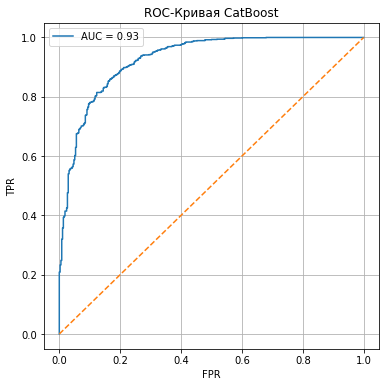

Значение меры recall =  0.9864734299516909
Значение меры precision =  0.8616033755274262


In [70]:
fig_roc_auc(best_CBC, 'CatBoost')

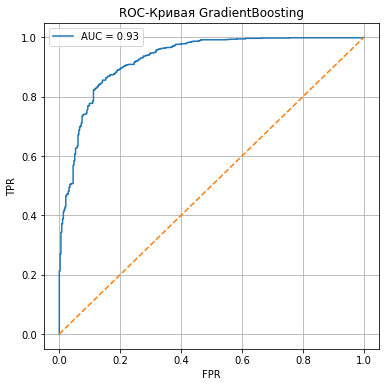

Значение меры recall =  0.9420289855072463
Значение меры precision =  0.8977900552486188


In [71]:
fig_roc_auc(best_GB, 'GradientBoosting')

Метрики моделей различаются не сильно, поэтому из-за долгой скорости обучения модели **CatBoostClassifier** думаю имеет смысл остановить свой выбор на **GradientBoostingClassifier**.
Рассмотрим матрицу ошибок для нее и важность признаков при обучении.

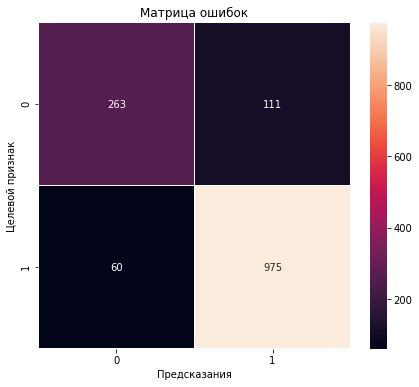

In [72]:
confusion_m(best_GB)

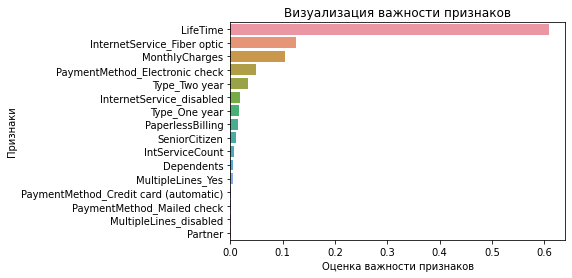

<Figure size 864x576 with 0 Axes>

In [73]:
his_feature_imp(best_GB)

#### Удаление лишних признаков

In [74]:
# удалим ненужные признаки(важность признаков оценена после обучения моделей)
columns_del = []
columns_imp = ['LifeTime',
               'InternetService_Fiber optic', 
               'MonthlyCharges', 
               'PaymentMethod_Electronic check']
for i in X_train.columns:
    if i not in columns_imp:
        columns_del.append(i)
X_train = X_train.drop(columns_del, axis=1)
X_test = X_test.drop(columns_del, axis=1)

In [75]:
%%time
gb_boost = GradientBoostingClassifier()
estim_list = [i for i in range(150,160,5)]
params = {'learning_rate':[0.001,0.05,0.1,0.5,1],'n_estimators':estim_list,'random_state':[RANDOM_STATE]}
model_types_compare,best_GB,best_GB_BP = find_best_model(gb_boost,
                                                         params,
                                                         X_train,
                                                         y_train,
                                                         X_test,
                                                         y_test,
                                                         model_types_compare,
                                                         'GradientBoostingClassifier_UPD',
                                                         'SL',
                                                         [])

,ROC AUC (test),ROC AUC (train),acc (test),acc (train),fit time,model_name
0,0.862795,0.872742,0.823989,0.824281,0.013037,DecisionTree
1,0.864344,0.907976,0.826118,0.837593,0.212811,RandomForest
2,0.844807,0.844293,0.811214,0.802804,0.495518,LogisticRegression
3,0.928114,0.982293,0.878637,0.942137,0.749501,GradientBoostingClassifier
4,0.926808,0.977312,0.873669,0.909123,7.547808,CatBoostClassifier
5,0.910405,0.998380,0.867991,0.981186,4.497887,LGBMClassifier
6,0.931774,0.978056,0.877218,0.934682,0.559112,GradientBoostingClassifier_UPD



Метрики для модели GradientBoostingClassifier_UPD (на тестовых данных)

Значение меры auc roc = 0.93177
Значение меры accuracy = 0.87722
Значение меры recall = 0.94976
Значение меры precision = 0.89040
Параметры лучшей модели:
{'learning_rate': 0.5, 'n_estimators': 155, 'random_state': 19612}
CPU times: user 22.4 s, sys: 128 ms, total: 22.5 s
Wall time: 22.5 s


## Вывод

В ходе выполнения проекта данные были объединены в одну таблицу, прошли предварительную обработку и были проанализированы. Были добавлены некоторые новые признаки(длительность действия договора в днях, количество дополнительных интернет-услуг и целевой признак, определяющий уход пользователя). Удалены или преобразованы признаки, которые были признаны несущественными, либо избыточными для предсказания оттока клиентов. Был выявлен дисбаланс классов, примерно 1:3.

Признаки были подготовлены к обучению(проведена кодировка и стандартизация). На подготовелнных данных обучены модели дерева решений, случайного леса, логистической регрессии и градиентного бустинга, дополнительно использовались бибклиотеки CatBoost, LightGBM. Лучше всего показали себя модели градиентного бустинга. 
По результатам тестирования лучших моделей выбор был остановлен на **GradientBoostingClassifier** из-за высоких значений метрик и скорости работы. 

После удаления малозначимых признаков и переобучении модели метрики стали следующими:
- **AUC-ROC** = 0.93170;
- **Accuracy** = 0.87722;
- **Recall** = 0.94976;
- **Precision** = 0.89040.

При этом уменьшилось время обучения модели практически на 30%. 

Что касается признаков, влияющих на предсказания модели, то можно выделить:
1. **LifeTime** - время жизни клиента (наиболее значимый признак);
2. **InternetService_Fiber optic** - подключение интернета через оптоволокно;
3. **MonthlyCharges** - ежемесячный платеж;
4. **PaymentMethod_Electronic check** - оплата электронным чеком.
Время жизни клиента - .


При анализе данных были сделаны следующие наблюдения и выводы: 
- отключаться клиенты начали с 2019 года и максимум отключившихся приходится на подключившихся в том же году; 
- среди ушедших клиентов преобладают люди допенсионного возраста, без детей и супруга, а так же те, что пользовался интернетом через оптоволокно; 
- около 90% ушедших клиентов пользовались помесячной оплатой услуг провайдера, так же в среднем месячная плата ушедших клиентов была выше, чем у оставшихся (медианное значение - 80 против 64 у оставшихся); 
- выяснилось, что чем меньше человек являлся клиентом компании, тем выше была вероятноть того, что он отключится: значительная часть клиентов ушли после первого-второго месяца пользования услуг компании.

Подытожив можно сказать, что у компании либо изменилась ценовая политика, либо по каким-то причинам понизилось качество оказываемых услуг и поддержки(вполне вероятно и из-за роста количества клиентом), либо появился конкурент.